In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.utils import to_categorical
from keras import backend as K
import numpy as np

# Load dataset
data = pd.read_csv('wdbc2.csv')

# Map categorical labels to numeric values
label_map = {'M': 1, 'B': 0}  # Map 'M' to 1 and 'B' to 0
data['Diagnosis'] = data['Diagnosis'].map(label_map)

# Preprocess data
X = data.drop('Diagnosis', axis=1).values
y = data['Diagnosis'].values
y = to_categorical(y)  # Convert labels to one-hot encoding

# Define 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_losses = []
fold_accuracies = []

# K-Fold Cross Validation
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape data for RNN
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build RNN model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(X_train.shape[1], 1), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Evaluate model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

    # Store metrics
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    # Clear Keras session to avoid clutter from old models and layers
    K.clear_session()

# Calculate and print average metrics
avg_loss = np.mean(fold_losses)
avg_accuracy = np.mean(fold_accuracies)
print(f'Average Loss: {avg_loss}')
print(f'Average Accuracy: {avg_accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Average Loss: 0.24228290716807047
Average Accuracy: 0.9156688253084818


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Average ROC AUC: 0.9843809981817404


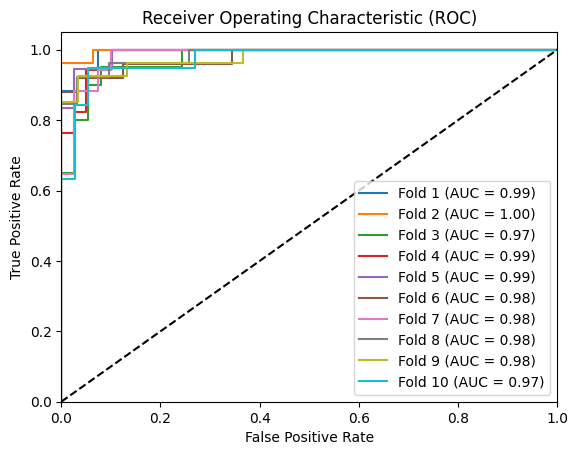

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input
from keras.utils import to_categorical
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('wdbc2.csv')

# Map categorical labels to numeric values
label_map = {'M': 1, 'B': 0}  # Map 'M' to 1 and 'B' to 0
data['Diagnosis'] = data['Diagnosis'].map(label_map)

# Preprocess data
X = data.drop('Diagnosis', axis=1).values
y = data['Diagnosis'].values
y = to_categorical(y)  # Convert labels to one-hot encoding

# Define 3-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_roc_auc = []
fpr_list = []
tpr_list = []

# K-Fold Cross Validation
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape data for RNN
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build RNN model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer to define input shape
    model.add(SimpleRNN(50, activation='relu'))
    #model.add(SimpleRNN(50, activation='relu', return_sequences=True))
    #model.add(SimpleRNN(50, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Predict probabilities
    y_pred_prob = model.predict(X_val)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val[:, 1], y_pred_prob[:, 1])  # Assuming binary classification (1 for positive class)
    roc_auc = auc(fpr, tpr)

    # Store ROC data
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    fold_roc_auc.append(roc_auc)

    # Clear Keras session to avoid clutter from old models and layers
    K.clear_session()

# Average ROC AUC
avg_roc_auc = np.mean(fold_roc_auc)
print(f'Average ROC AUC: {avg_roc_auc}')

# Plot ROC Curve
plt.figure()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {fold_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Overall ROC AUC: 0.9670736219015907


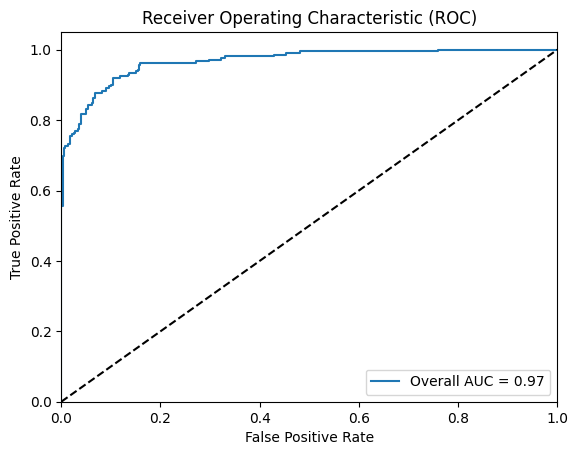

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input
from keras.utils import to_categorical
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('wdbc2.csv')

# Map categorical labels to numeric values
label_map = {'M': 1, 'B': 0}  # Map 'M' to 1 and 'B' to 0
data['Diagnosis'] = data['Diagnosis'].map(label_map)

# Preprocess data
X = data.drop('Diagnosis', axis=1).values
y = data['Diagnosis'].values
y = to_categorical(y)  # Convert labels to one-hot encoding

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store all true labels and predictions
all_y_true = []
all_y_pred_prob = []

# K-Fold Cross Validation
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape data for RNN
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build RNN model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input layer to define input shape
    model.add(SimpleRNN(50, activation='relu'))
    #model.add(SimpleRNN(30, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Predict probabilities
    y_pred_prob = model.predict(X_val)

    # Append true labels and predictions to lists
    all_y_true.append(y_val[:, 1])
    all_y_pred_prob.append(y_pred_prob[:, 1])

    # Clear Keras session to avoid clutter from old models and layers
    K.clear_session()

# Concatenate all true labels and predicted probabilities
all_y_true = np.concatenate(all_y_true)
all_y_pred_prob = np.concatenate(all_y_pred_prob)

# Compute ROC curve and AUC for overall model
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_prob)
roc_auc = auc(fpr, tpr)

# Print average ROC AUC
print(f'Overall ROC AUC: {roc_auc}')

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Overall AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
